In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
%load_ext watermark

In [3]:
# watermark
%watermark -v -n -m -p numpy -g

Sun Feb 10 2019 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 731adcc574bdbcea2c599be0437c614aff15c785


# Executive Summary 

# Ideas for notebook 
- execute data make file from notebook
- notebook will serve more as a dashboard and report 
- consider spark lines to show evolution of click thru rates

# Metric Goals

In order to have an efficient ad campaign we prefer high percentage metrics and low cost metrics. Some available metrics include: 

- **Click Through Rate (CTR)** percentage of impressions that turn into clicks 
- **Conversion Rate** percentage of clicks that convert to actions taken
- **Cost per Click (CPC)** total spend divided by total clicks 
- **Cost per Acquisition (CPA)** total spend / total conversions

Given the metrics included in the **Data schema** below, we'll focus on **CTR** and **CPC** metrics for global and regional campaigns. If the table had conversion data, then we could analyze conversions metrics as well. 

# Load Data

## Data schema 
- date : date the data was recorded
- country : country the data was recorded for
- keyword : keyword associated with the campaign
- global_monthly_searches : total monthly searches for that keyword on google globally
- ad_position : how close to the top of the search result page the ad appeared (1 is the top)
- daily_clicks : number of clicks that occurred that day for the keyword
- daily_cost : amount of money spent for the clicks on that keyword on that day
- local_monthly_searches : total monthly searches for that keyword on google for the country
- impressions : number of times the ad was shown to a user that day for that keyword

In [107]:
file_location = 'data/raw/data_challenge.csv'
data = pd.read_csv(file_location, index_col='date')
data.index = pd.to_datetime(data.index)
data.head()

,country,keyword,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions
date,,,,,,,,
2011-12-25,UK,financial services,4090000.0,1.0,8.0,234.22,246000.0,4757
2011-12-25,UK,certificate of deposit,1830000.0,1.0,148.0,159.49,201000.0,60635
2011-12-25,UK,joint account,201000.0,1.0,1.0,0.20,8100.0,26
2011-12-25,UK,insurance,33100.0,1.0,28.0,490.98,6600.0,34975
2011-12-25,UK,checking account,450000.0,1.0,50.0,133.00,33100.0,16997


# Efficiency metrics

## CTR

In [108]:
# define click thru rate
data['CTR'] = data['daily_clicks'] / data['impressions']

### US CTR rankings (by mean values)

In [109]:
region = 'US'
def rank_ctr(data, region):
    df = data[data['country']==region].groupby('keyword')[['CTR']].agg('mean').sort_values(by='CTR', ascending=False)
    return df 
us_ctr = rank_ctr(data, region)
us_ctr

,CTR
keyword,
banking careers,0.064094
rewards card,0.059658
bankruptcy,0.047311
interest rate,0.046541
debit,0.037072
atm,0.034837
credit cards,0.029102
mortgage,0.026018
lawyer,0.015995


### UK CTR rankings (by mean values)

In [110]:
region = 'UK'
uk_ctr = rank_ctr(data, region)
uk_ctr

,CTR
keyword,
bankruptcy,0.063706
atm,0.052742
credit cards,0.052474
overdraft fee,0.050241
joint account,0.049761
debit,0.048501
interest rate,0.044282
rewards card,0.042312
banking careers,0.037037


## CPC

In [121]:
# define daily CPC, total spend / total clicks 
data['CPC'] = data['daily_cost'] / data['daily_clicks']
# replace inf with None, this handles days with zero clicks
data['CPC'].replace(np.inf, None, inplace=True)

### US CPC rankings (by mean values)

In [122]:
region = 'US'
def rank_cpc(data, region):
    df = data[(data['country']==region) ].groupby('keyword')[['CPC']].agg('mean').sort_values(by='CPC')
    return df 
us_cpc = rank_cpc(data, region)
us_cpc

,CPC
keyword,
financial services,0.356532
banking careers,0.805990
minimum balance,0.809601
interest rate,0.918934
bankruptcy,1.130540
lawyer,1.364759
rewards card,1.938794
certificate of deposit,3.316022
consolidate loans,3.845810


### UK CPC rankings (by mean values)

In [123]:
region = 'UK'
uk_cpc = rank_cpc(data, region)
uk_cpc

,CPC
keyword,
credit cards,0.367292
debit,0.373333
rewards card,0.522535
banking careers,0.532143
interest rate,0.772643
bankruptcy,0.824024
atm,0.957555
lawyer,1.390875
overdraft fee,1.493898


In [68]:
# Rank the 19 search items 
search_items = list(data['keyword'].unique())
search_dict = {'keywords':[], 'global_monthly_searches':[], 'CTR':[]}
for item in search_items:
    search_dict['keywords'].append(item)
    search_dict['global_monthly_searches'].append(data[data['keyword']==item]['global_monthly_searches'].max())
    search_dict['CTR'].append(100*data[data['keyword']==item]['daily_clicks'].sum()/data[data['keyword']==item]['impressions'].sum())

search_df = pd.DataFrame(search_dict).sort_values(by='CTR', ascending=False).reset_index(drop=True)
search_df

,keywords,global_monthly_searches,CTR
0,banking careers,480.0,5.992350
1,bankruptcy,8100.0,5.128682
2,atm,1300.0,1.540185
3,rewards card,1000000.0,1.135013
4,debit,1500000.0,0.982193
5,mortgage,9900.0,0.735317
6,interest rate,1500000.0,0.646812
7,consolidate loans,90500.0,0.144220
8,certificate of deposit,1830000.0,0.143005
9,minimum balance,1220000.0,0.121008


In [114]:
 data[(data['country'] == 'UK') & (data['keyword'] == 'atm')].sort_values(by='daily_clicks')

,country,keyword,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions,CTR
date,,,,,,,,,
2012-03-11,UK,atm,1000.0,1.00,0.0,1.290,110.0,26,0.000000
2012-03-13,UK,atm,1000.0,1.00,0.0,1.510,110.0,26,0.000000
2012-03-12,UK,atm,1000.0,1.00,0.0,1.290,110.0,26,0.000000
2012-03-05,UK,atm,1000.0,1.00,1.0,1.220,110.0,29,0.034483
2012-03-06,UK,atm,1000.0,1.00,1.0,1.220,110.0,29,0.034483
2012-03-07,UK,atm,1000.0,1.00,1.0,1.230,110.0,29,0.034483
2012-03-08,UK,atm,1000.0,1.00,1.0,1.230,110.0,29,0.034483
2012-03-09,UK,atm,1000.0,1.00,1.0,1.430,110.0,31,0.032258
2012-03-10,UK,atm,1000.0,1.00,1.0,1.230,110.0,29,0.034483


In [60]:
df = data[(data['country'] == 'UK') & (data['keyword'] == 'financial services')][['click_thru_rate']]

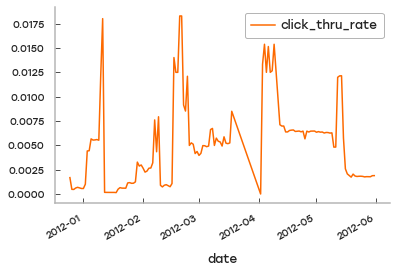

In [61]:
df.plot()

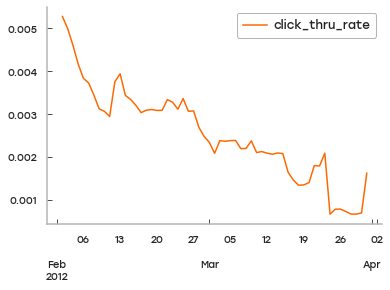

In [58]:
df[(df.index>'2012-02') & (df.index<'2012-04')].plot()
plt.xlabel('');

In [8]:
data.describe()

,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions,click_thru_rate
count,3.896000e+03,3898.000000,3916.000000,3900.00000,3.916000e+03,3.916000e+03,3916.000000
mean,3.247633e+06,1.017731,737.821502,4042.45178,9.838095e+05,6.587655e+07,0.015444
std,6.072622e+06,0.023904,1918.515192,13628.77784,2.478468e+06,3.031724e+08,0.032189
min,0.000000e+00,1.000000,0.000000,0.10000,0.000000e+00,2.600000e+01,0.000000
25%,3.310000e+04,1.000000,7.000000,30.20000,5.400000e+03,7.702500e+02,0.000409
50%,2.010000e+05,1.000000,78.000000,186.49500,1.100000e+05,4.708950e+04,0.002058
75%,1.830000e+06,1.050000,318.250000,922.90250,3.010000e+05,5.483572e+05,0.011600
max,2.040000e+07,1.100000,13299.000000,98244.74000,1.110000e+07,2.587009e+09,0.376923


In [ ]:
data